In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp
import numpy as np

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.dynamics_aware_fb import DynamicsForwardBackwardAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

In [2]:
def random_exploration(env, num_episodes=100, num_steps=200, layout_type: int = 1):
    coverage_map = np.where(env.maze_state == 1, -100, 0)
    dataset = dict()
    observations = []
    actions = []
    dones = []

    for _ in range(num_episodes):
        i=0
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        cur_observations = []
        cur_actions = []
        cur_dones = []
        
        while i < num_steps:
            i+=1
            cur_observations.append(np.array(state, dtype=np.float32))
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            cur_dones.append(np.array(False, dtype=np.float32))
            coverage_map[next_state[0], next_state[1]] += 1
            state = next_state
            
        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
        
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask][:, None]
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    dataset['layout_type'] = np.repeat(np.array(layout_type), repeats=(dataset['actions'].shape[0], ))
    return coverage_map, dataset

def visualize_coverage_map(coverage_map, name):
    plt.imshow(coverage_map, cmap='inferno', vmin=0)
    plt.colorbar()
    plt.title(f'Coverage Map for {name}')
    plt.show()

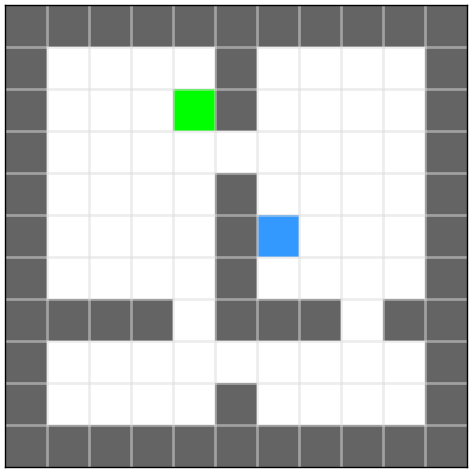

In [3]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

fourrooms_env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
fourrooms_env.reset()
fourrooms_env.render(return_img=False)

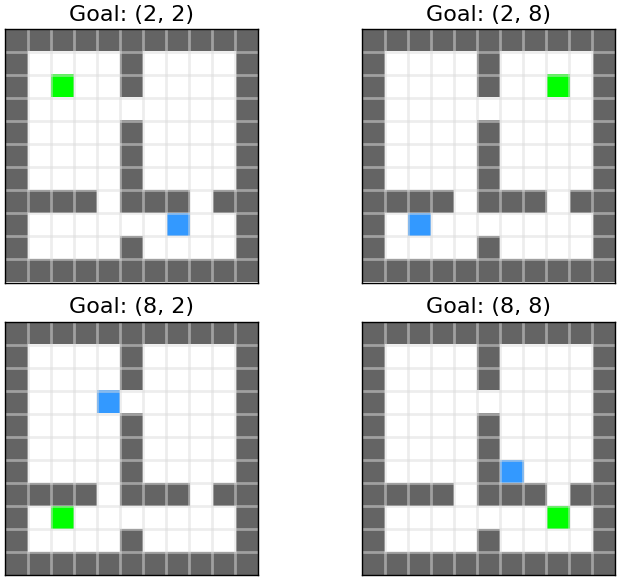

In [4]:
fourrooms_env.visualize_goals()

In [5]:
from utils.datasets import Dataset

NUM_LAYOUTS = 10
train_layout_data = []
for i in tqdm(range(NUM_LAYOUTS)):
    fourrooms_env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
    coverage_map_random, dataset_random = random_exploration(fourrooms_env, layout_type=i)
    train_layout_data.append(dataset_random)

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
import functools

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=discrete_transformer.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
np.save("../aux_data/fourrooms_meta_data", arr=jax.device_get(whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

test_sample = gc_whole_dataset.sample(10, layout_type=1, context_length=20)[1]

{
│   'seed': 1337,
│   'run_group': 'dynamics_aware_fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 5000,
│   'eval_interval': 10000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'dynamics_aware_fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 150,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'n_blocks': 4,
│   │   'n_heads': 5,
│   │   'h_dim': 150,
│   │   'context_len': 1024,
│   │   'number_of_meta_envs': 10,
│   │   'f_hidden_dims': [512, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True
│   },
│   'env': {'env_name': 'gridworld', 'discrete': True},
│   'tags': ['dynamical_fb', 'discrete']
}

In [7]:
jax.tree.map(lambda x: x.shape, test_sample)

{'actions': (10, 20, 1),
 'layout_type': (10, 20, 1),
 'next_observations': (10, 20, 2),
 'observations': (10, 20, 2),
 'terminals': (10, 20, 1)}

In [8]:
example_batch = gc_whole_dataset.sample(1)

fb_agent = DynamicsForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], fourrooms_env.action_space.n - 1),
    config=fb_config['agent']
)

In [9]:
batch, batch_context = gc_whole_dataset.sample(10, layout_type=1, context_length=100)
fb_agent.update(batch, batch_context)

(DynamicsForwardBackwardAgent(rng=Array((), dtype=key<fry>) overlaying:
 [4165894930  804218099], network=TrainState(step=Array(2, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of ModuleDict(
     # attributes
     modules = {'f_value': FValueDiscrete(
         # attributes
         latent_z_dim = 150
         action_dim = 4
         f_hidden_dims = [512, 512, 512]
         f_layer_norm = True
     ), 'target_f_value': FValueDiscrete(
         # attributes
         latent_z_dim = 150
         action_dim = 4
         f_hidden_dims = [512, 512, 512]
         f_layer_norm = True
     ), 'b_value': BValue(
         # attributes
         latent_z_dim = 150
         b_hidden_dims = [512, 512, 512]
         b_layer_norm = True
     ), 'target_b_value': BValue(
         # attributes
         latent_z_dim = 150
         b_hidden_dims = [512, 512, 512]
         b_layer_norm = True
     ), 'dynamics_encoder': DynamicsTransformer(
         # attributes
         n_blocks = 4
   

In [10]:
# with jax.disable_jit():
for step in tqdm(range(15_000)):
    batch, batch_context = gc_whole_dataset.sample(8, layout_type=step % 5, context_length=fb_config['agent']['context_len'])
    fb_agent, info = fb_agent.update(batch, batch_context)
info

  0%|          | 0/15000 [00:00<?, ?it/s]

: 

In [ ]:
batch, batch_context = gc_whole_dataset.sample(1, layout_type=1, context_length=100)
z = fb_agent.sample_z(1, 150, GLOBAL_KEY)

In [ ]:
context_type = fb_agent.network.select('dynamics_encoder')(batch_context['observations'], batch_context['actions'],
                                                           layout_type=batch_context['layout_type'], predict_type=True)

In [ ]:
fb_agent.network.select('dynamics_encoder')(batch_context['observations'], batch_context['actions'], predict_type=False)

Array([[ 4.36697036e-01,  1.55209914e-01, -1.45636141e+00,
        -8.04618716e-01, -4.03161854e-01, -4.84473675e-01,
         1.81745693e-01,  4.54472572e-01,  6.84562445e-01,
        -1.31797820e-01,  2.59977758e-01,  1.30867869e-01,
         5.21020710e-01,  9.12212968e-01, -2.01500785e-02,
        -2.67933279e-01,  2.47087032e-01, -3.03491890e-01,
         7.93957531e-01,  1.08631420e+00,  3.34315389e-01,
         1.99934915e-01,  5.62920198e-02,  1.51743412e-01,
         1.25338435e+00, -2.39187986e-01, -1.75825119e+00,
         1.13567030e+00, -1.41893968e-01,  1.08554423e+00,
         5.49063265e-01,  5.93659937e-01,  1.31463492e+00,
        -8.97713471e-04,  1.43981254e+00,  2.10592733e-03,
        -8.13719332e-01,  1.57538489e-01, -1.90105820e+00,
        -3.90895188e-01, -1.65495053e-01, -7.03363359e-01,
         6.09771945e-02,  1.86925922e-02,  1.21312894e-01,
         1.79023051e+00, -5.91157913e-01,  8.45295966e-01,
        -1.68681991e+00,  4.26918447e-01,  3.63562405e-0

In [ ]:
context_type

Array([[[ 1.9776514 , -6.3769374 ,  5.7189255 ,  3.0882642 ,
         -5.1917424 ],
        [ 0.4353333 , -8.12344   ,  7.7140527 ,  6.808108  ,
         -7.9729652 ],
        [ 1.8749042 , -2.2425625 ,  2.5197384 ,  0.5654152 ,
         -1.3870721 ],
        [ 1.5973711 ,  1.816171  , -1.8247252 , -4.3441415 ,
          2.5440598 ],
        [ 1.6316873 ,  2.9459398 , -2.9284976 , -5.6673784 ,
          3.9046648 ],
        [ 1.5897198 ,  3.2251613 , -3.2347915 , -6.041266  ,
          4.3429837 ],
        [ 1.7394543 ,  2.7651808 , -2.1079862 , -4.457774  ,
          3.724753  ],
        [ 1.2112195 ,  1.2193791 , -1.5049632 , -3.7764063 ,
          2.2140636 ],
        [ 1.1504015 ,  1.1182657 , -1.3977791 , -3.637102  ,
          2.1434264 ],
        [ 1.1807044 , -0.22326913,  0.715315  , -0.71399635,
          0.36496586],
        [ 1.0205109 ,  0.41709813, -0.7946063 , -2.8190162 ,
          1.370047  ],
        [ 0.7475091 , -0.5417672 ,  0.15092993, -1.4942936 ,
          0.187

In [ ]:
def random_exploration(env, context_len: int = 512, layout_type: int = 1):
    # for inference context
    coverage_map = np.where(env.maze_state == 1, -100, 0)
    dataset = dict()
    observations = []
    actions = []
    dones = []

    for _ in range(1):
        i=0
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        cur_observations = []
        cur_actions = []
        cur_dones = []
        
        while i < context_len:
            i+=1
            cur_observations.append(np.array(state, dtype=np.float32))
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            cur_dones.append(np.array(False, dtype=np.float32))
            coverage_map[next_state[0], next_state[1]] += 1
            state = next_state
            
        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask][None]
    dataset['observations'] = dataset['observations'][ob_mask][None]
    dataset['actions'] = dataset['actions'][ob_mask][None, :, None]
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)[None, :, None]
    dataset['layout_type'] = np.repeat(np.array(layout_type), repeats=(dataset['actions'].shape[1], ))[None, :, None]
    return coverage_map, dataset

def visualize_coverage_map(coverage_map, name):
    plt.imshow(coverage_map, cmap='inferno', vmin=0)
    plt.colorbar()
    plt.title(f'Coverage Map for {name}')
    plt.show()

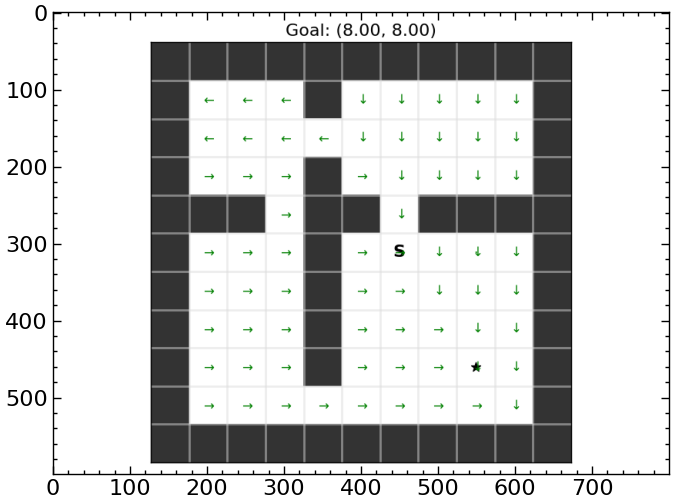

In [ ]:
from envs.custom_mazes.env_utils import policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng

fourrooms_env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
fourrooms_env.reset()

observation, info = fourrooms_env.setup_goals(seed=None, task_num=4)
goal = info.get("goal_pos", None)
batch, batch_context = gc_whole_dataset.sample(1, layout_type=1, context_length=512) # sample context from meta-train
# print(batch_context['observations'].shape)
coverage_map_random, dataset_random = random_exploration(fourrooms_env, layout_type=5, context_len=512) # sample context from random exploration in env, new layout
# print(dataset_random['observations'].shape)
batch_context = jax.tree.map(lambda x, y: jnp.concatenate([x, y], 1), batch_context, dataset_random)

context_embed = fb_agent.network.select('dynamics_encoder')(batch_context['observations'], batch_context['actions'], layout_type=batch_context['layout_type'],
                                                            predict_type=False)
latent_z = fb_agent.infer_z(goal[None], context_emb=context_embed)
start = info.get("start_pos", None)
example_batch = whole_dataset.sample(1)
N, M = fourrooms_env.maze.size
pred_policy_img = policy_image_fourrooms(fourrooms_env, example_batch, N=N, M=M,
                                                action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                  latent_z=latent_z, context_embed=context_embed, temperature=0.0),
                                                goal=goal, start=start)
plt.imshow(pred_policy_img)

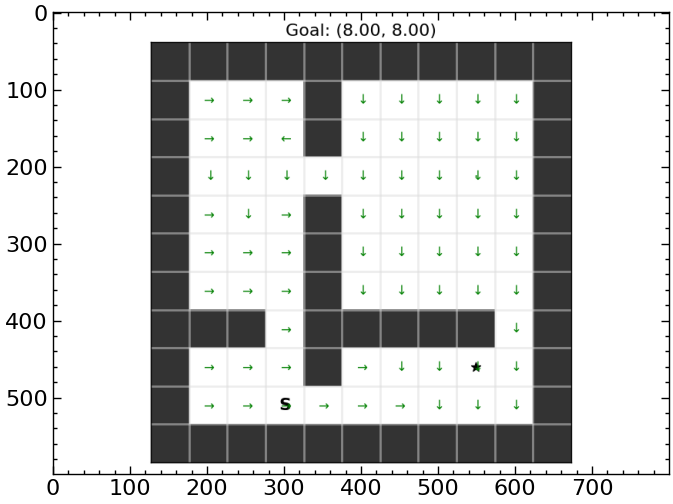

In [ ]:
from envs.custom_mazes.env_utils import policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng

fourrooms_env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
fourrooms_env.reset()

observation, info = fourrooms_env.setup_goals(seed=None, task_num=4)
goal = info.get("goal_pos", None)
batch, batch_context = gc_whole_dataset.sample(1, layout_type=1, context_length=512)
coverage_map_random, dataset_random = random_exploration(fourrooms_env, layout_type=5, context_len=512) # sample context from random exploration in env, new layout
batch_context = jax.tree.map(lambda x, y: jnp.concatenate([x, y], 1), batch_context, dataset_random)
context_embed = fb_agent.network.select('dynamics_encoder')(batch_context['observations'], batch_context['actions'], layout_type=batch_context['layout_type'],
                                                            predict_type=False)

latent_z = fb_agent.infer_z(goal[None], context_emb=context_embed)
start = info.get("start_pos", None)
example_batch = whole_dataset.sample(1)
N, M = fourrooms_env.maze.size
pred_policy_img = policy_image_fourrooms(fourrooms_env, example_batch, N=N, M=M,
                                                action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                  latent_z=latent_z, context_embed=context_embed, temperature=0.0),
                                                goal=goal, start=start)
plt.imshow(pred_policy_img)

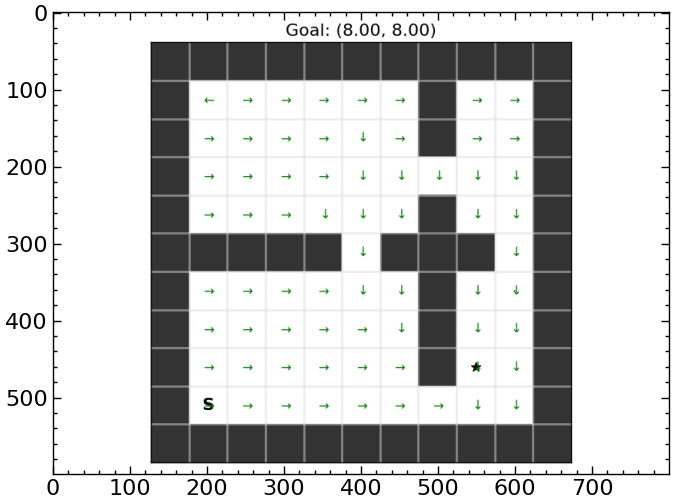

In [ ]:
from envs.custom_mazes.env_utils import policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng

fourrooms_env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
fourrooms_env.reset()

observation, info = fourrooms_env.setup_goals(seed=None, task_num=4)
goal = info.get("goal_pos", None)
batch, batch_context = gc_whole_dataset.sample(1, layout_type=1, context_length=512)
coverage_map_random, dataset_random = random_exploration(fourrooms_env, layout_type=5, context_len=512) # sample context from random exploration in env, new layout
batch_context = jax.tree.map(lambda x, y: jnp.concatenate([x, y], 1), batch_context, dataset_random)
context_embed = fb_agent.network.select('dynamics_encoder')(batch_context['observations'], batch_context['actions'], layout_type=batch_context['layout_type'],
                                                            predict_type=False)
latent_z = fb_agent.infer_z(goal[None], context_emb=context_embed)
start = info.get("start_pos", None)
example_batch = whole_dataset.sample(1)
N, M = fourrooms_env.maze.size
pred_policy_img = policy_image_fourrooms(fourrooms_env, example_batch, N=N, M=M,
                                                action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                  latent_z=latent_z, context_embed=context_embed, temperature=0.0),
                                                goal=goal, start=start)
plt.imshow(pred_policy_img)

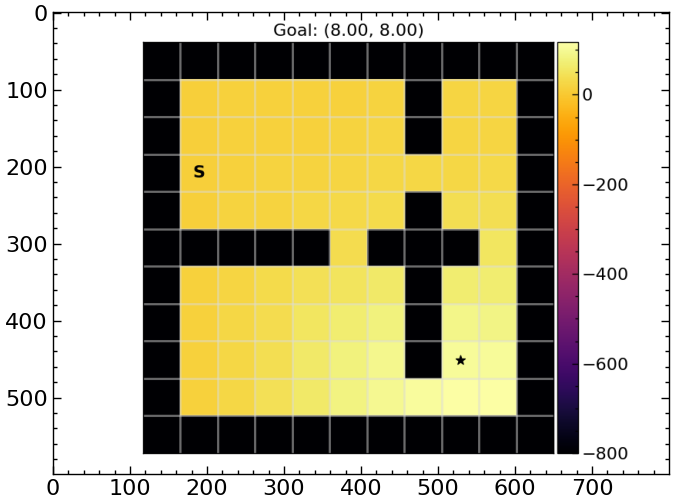

In [ ]:
from envs.custom_mazes.env_utils import value_image_fourrooms
from functools import partial

observation, info = fourrooms_env.setup_goals(seed=None, task_num=4)
goal = info.get("goal_pos", None)
context_embed = fb_agent.network.select('dynamics_encoder')(batch_context['observations'], batch_context['actions'],
                                                            layout_type=batch_context['layout_type'], predict_type=False)
latent_z = fb_agent.infer_z(goal[None], context_emb=context_embed)
N, M = fourrooms_env.maze.size
pred_value_img = value_image_fourrooms(fourrooms_env, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, context_embed=context_embed, z=latent_z), goal=goal)
plt.imshow(pred_value_img)